In [1]:
!pip install pm4py
!pip install optuna

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 17.8 MB/s eta 0:00:00
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26097 sha256=20068e1f8f82823b57e0b273fad6bd7c7ccce69e234231343f1d72e9ae7b982b
  Stored in directory: /root/.cache/pip/wheels/fa/80/8c/43488a924a046b733b64de3fac99252674c892a4c3801c0a61
Successfully built intervaltree
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [2]:
log_url = "https://data.4tu.nl/datasets/6a0a26d2-82d0-4018-b1cd-89afb0e8627f"

In [3]:
import pm4py
import optuna
import pandas as pd
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristic_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.evaluation.replay_fitness import algorithm as fitness_evaluator
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from pm4py.objects.petri_net.utils.check_soundness import check_easy_soundness_net_in_fin_marking
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.statistics.traces.generic.pandas import case_statistics

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


**Choose dataset**

In [5]:
# Domestic declarations log
log = pm4py.read_xes('DomesticDeclarations.xes')

/usr/local/lib/python3.10/dist-packages/pm4py/util/dt_parsing/parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/10500 [00:00<?, ?it/s]

In [ ]:
# Italian helpdesk log
data = pd.read_csv('finale.csv')
data.rename(columns={
    'Case ID': 'case:concept:name',
    'Activity': 'concept:name',
    'Complete Timestamp': 'time:timestamp'
}, inplace=True)

# Convert the timestamp column to datetime format
data['time:timestamp'] = pd.to_datetime(data['time:timestamp'])

# Ensure the activity names are treated as strings
data['concept:name'] = data['concept:name'].astype(str)
log = data

In [ ]:
log

[{'attributes': {'concept:name': 'Case 1'}, 'events': [{'concept:name': 'Assign seriousness', 'Resource': 'Value 1', 'time:timestamp': Timestamp('2012-10-09 14:50:17'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 1', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}, '..', {'concept:name': 'Closed', 'Resource': 'Value 3', 'time:timestamp': Timestamp('2012-11-09 12:54:39'), 'Variant': 'Variant 12', 'Variant index': 12, 'Variant.1': 'Variant 12', 'seriousness': 'Value 1', 'customer': 'Value 1', 'product': 'Value 1', 'responsible_section': 'Value 1', 'seriousness_2': 'Value 1', 'service_level': 'Value 2', 'service_type': 'Value 1', 'support_section': 'Value 1', 'workgroup': 'Value 1'}]}, '....', {'attributes': {'concept:name': 'Case 4580'}, 'events': [{'concept:name': 'Take i

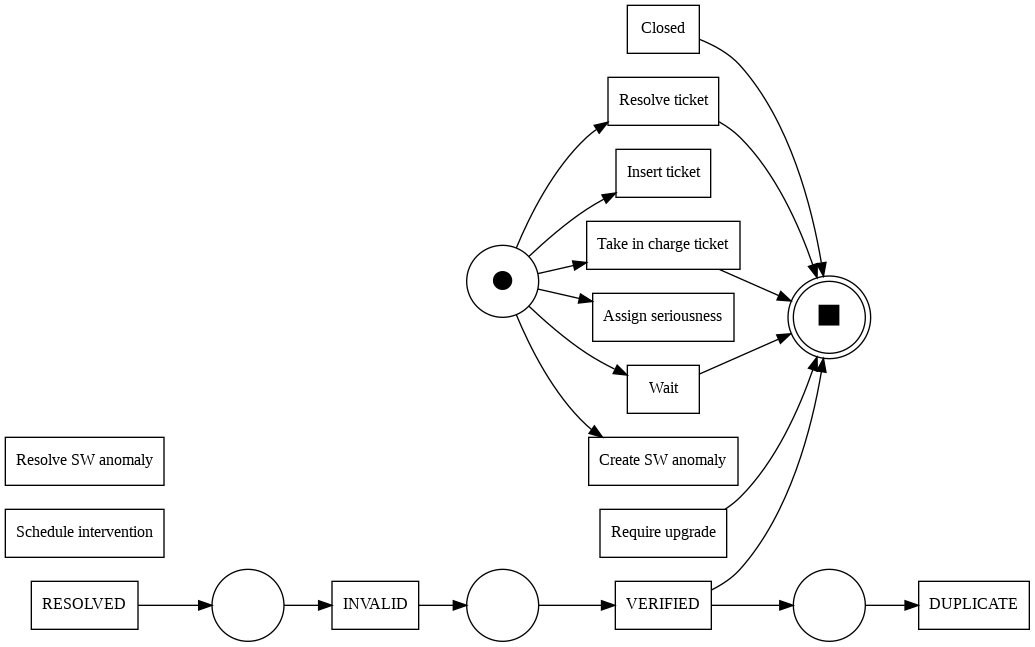

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_alpha(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

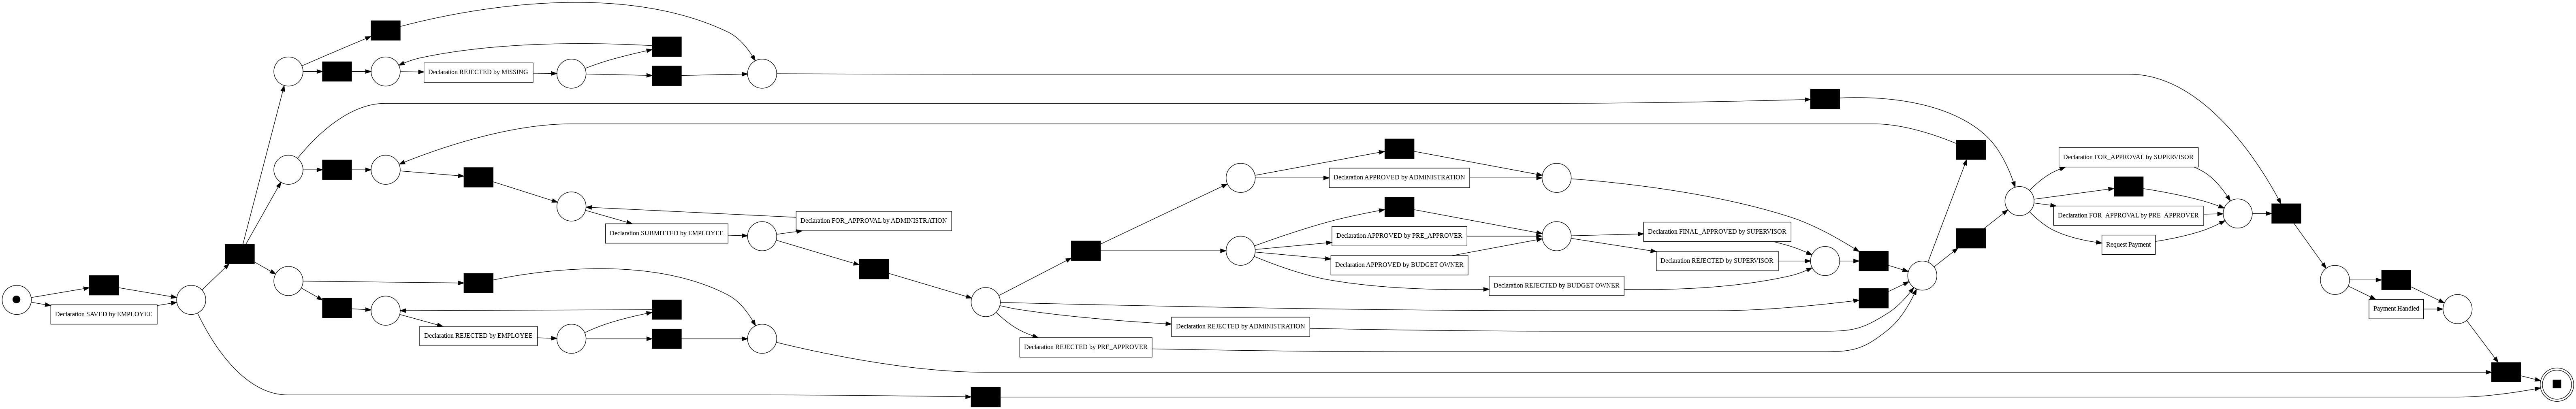

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

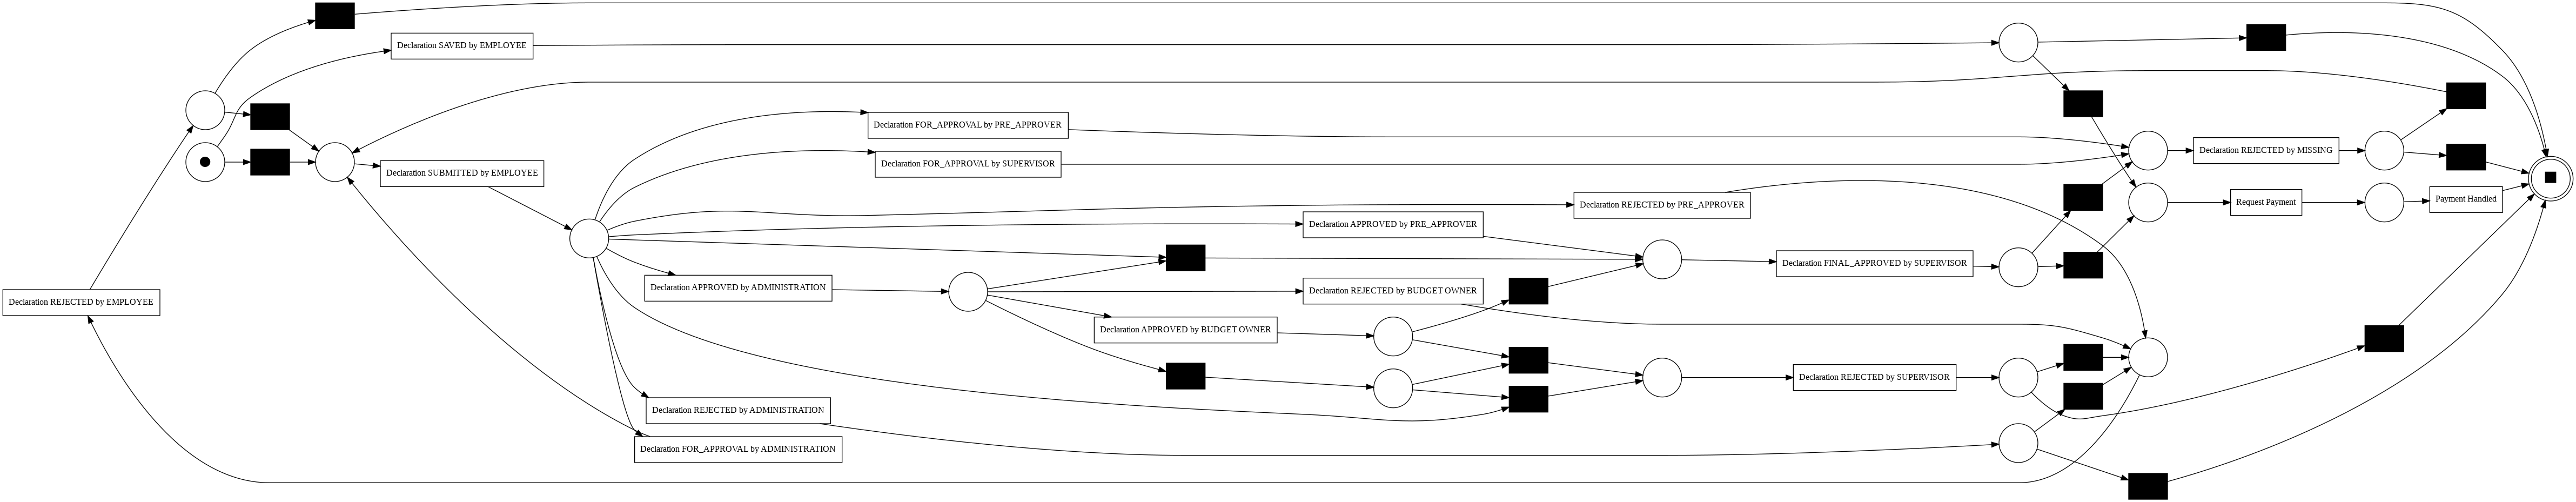

In [ ]:
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(log)
pm4py.vis.view_petri_net(net, initial_marking, final_marking)

In [6]:
"""
Functions for evaluation
"""

def evaluate_fitness(net, initial_marking, final_marking, log):
    # Check if the produced net has sound structure or not
    is_sound = check_easy_soundness_net_in_fin_marking(net, initial_marking, final_marking)

    if is_sound:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.ALIGNMENT_BASED
        )
    else:
        fitness_results = fitness_evaluator.apply(
            log, net, initial_marking, final_marking, variant=fitness_evaluator.TOKEN_BASED
        )

    return fitness_results["log_fitness"]

def evaluate_simplicity(net, weight_places=1, weight_transitions=2, weight_arcs=1):
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)

    # Calculate complexity
    complexity = (
        weight_places * num_places +
        weight_transitions * num_transitions +
        weight_arcs * num_arcs
    )
    simplicity = 1 / (complexity + 1)  # Get inverse, +1 is for non-zero division
    return simplicity

def evaluate_generalization(net, initial_marking, final_marking, log):
    # Trace coverage
    replay_results = token_replay.apply(log, net, initial_marking, final_marking)
    fully_replayed = sum(1 for res in replay_results if res['trace_is_fit'])
    trace_coverage = fully_replayed / len(replay_results) if replay_results else 0

    # Model complexity vs. log variability
    unique_traces = case_statistics.get_variant_statistics(log)
    num_unique_traces = len(unique_traces)
    num_places = len(net.places)
    num_transitions = len(net.transitions)
    num_arcs = len(net.arcs)
    model_complexity = num_places + num_transitions + num_arcs
    variability_ratio = num_unique_traces / (model_complexity + 1)
    # Final score
    generalization = (trace_coverage * 0.6) + (variability_ratio * 0.4)
    return generalization

In [7]:
def apply_alpha(log):
    net, initial_marking, final_marking = alpha_miner.apply(log)
    return net, initial_marking, final_marking

def apply_heuristic(log, parameters):
    net, initial_marking, final_marking = heuristic_miner.apply(log, parameters=parameters)
    return net, initial_marking, final_marking

def apply_inductive(log, noise_threshold=0.0):
    parameters = {"noise_threshold": noise_threshold}
    process_tree = inductive_miner.apply(log, parameters=parameters)
    # inductive returns process tree which needs to be converted to petri-net
    net, initial_marking, final_marking = pt_converter.apply(process_tree)
    return net, initial_marking, final_marking

In [8]:
def objective(trial):
    # algorithm selection
    algorithm = trial.suggest_categorical("algorithm", ["alpha", "heuristic", "inductive"])
    if algorithm == "alpha":
        net, initial_marking, final_marking = apply_alpha(log)
    elif algorithm == "heuristic":
        dependency_thresh = trial.suggest_float("dependency_thresh", 0.0, 1.0)
        and_measure_thresh = trial.suggest_float("and_measure_thresh", 0.5, 1.0)
        loop_two_thresh = trial.suggest_float("loop_two_thresh", 0.0, 1.0)
        parameters = {
        "dependency_thresh": dependency_thresh,
        "and_measure_thresh": and_measure_thresh,
        "loop_two_thresh": loop_two_thresh
        }
        net, initial_marking, final_marking = apply_heuristic(log, parameters=parameters)
    elif algorithm == "inductive":
        noise_threshold = trial.suggest_float("noise_threshold", 0.0, 0.3)
        net, initial_marking, final_marking = apply_inductive(log, noise_threshold=noise_threshold)

    # evaluation metrics
    fitness = evaluate_fitness(net, initial_marking, final_marking, log)
    simplicity = evaluate_simplicity(net)
    generalization = evaluate_generalization(net, initial_marking, final_marking, log)
    combined_score = fitness * 0.6 + simplicity * 0.2 + generalization * 0.2

    return combined_score

In [9]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2024-12-15 18:49:24,276] A new study created in memory with name: no-name-223bbab3-6baa-4836-a6a7-424a73365d8f


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:29,691] Trial 0 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06432221648604904}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:32,162] Trial 1 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:37,576] Trial 2 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.07509175385192904}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:40,684] Trial 3 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.24378087330746323, 'and_measure_thresh': 0.87777454553982, 'loop_two_thresh': 0.2547440428332973}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:44,902] Trial 4 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.6662471683871317, 'and_measure_thresh': 0.5488994729735888, 'loop_two_thresh': 0.3272156645306221}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:49,559] Trial 5 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.0023899872269990464}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:51,577] Trial 6 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:56,948] Trial 7 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.21930805294685507}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:49:59,437] Trial 8 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:04,222] Trial 9 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.09364485453451506}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:09,175] Trial 10 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.2993242813952751}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:14,639] Trial 11 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06923000682389442}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:19,270] Trial 12 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.09651067035641953}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:25,027] Trial 13 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.015660695279474064}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:29,730] Trial 14 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.15282058511766583}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:32,693] Trial 15 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9377378115603341, 'and_measure_thresh': 0.9734055541231281, 'loop_two_thresh': 0.9984604427127367}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:38,558] Trial 16 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.16724436414163707}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:43,401] Trial 17 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06318743879208188}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:46,362] Trial 18 finished with value: 0.6804436791346526 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.05744632157848639, 'and_measure_thresh': 0.5071803125564123, 'loop_two_thresh': 0.8210135776496774}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:48,429] Trial 19 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:54,113] Trial 20 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.11733689439359862}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:50:58,633] Trial 21 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.016486922822462058}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:03,773] Trial 22 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.009989102107863704}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:09,213] Trial 23 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.048637849413861955}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:13,743] Trial 24 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.04397053006846409}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:19,628] Trial 25 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.0013289131527165488}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:24,311] Trial 26 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.12297367659207348}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:29,018] Trial 27 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.037480770138221806}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:33,315] Trial 28 finished with value: 0.6585010590953313 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.5339733004635847, 'and_measure_thresh': 0.7342243249058612, 'loop_two_thresh': 0.03686987941837194}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:35,431] Trial 29 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:37,548] Trial 30 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:42,202] Trial 31 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.19431279750678151}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:48,121] Trial 32 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.22710021341854744}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:52,716] Trial 33 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.24386930321074365}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:51:55,827] Trial 34 finished with value: 0.6726239136966062 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.9748649064728575, 'and_measure_thresh': 0.7104991989820794, 'loop_two_thresh': 0.6447456265911141}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:01,652] Trial 35 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.19557848888360174}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:06,365] Trial 36 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.08143258133709967}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:08,468] Trial 37 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:14,283] Trial 38 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1238696021774562}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:19,065] Trial 39 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.26605841766927024}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:22,456] Trial 40 finished with value: 0.6397636257043636 and parameters: {'algorithm': 'heuristic', 'dependency_thresh': 0.26689748541836195, 'and_measure_thresh': 0.6450704764458796, 'loop_two_thresh': 0.5205025454849485}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:28,152] Trial 41 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.0925381037229441}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:32,972] Trial 42 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.10001044775051951}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:37,773] Trial 43 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.03383103308666136}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:43,696] Trial 44 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.06737705082362123}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:48,402] Trial 45 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.28321807353980266}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:53,873] Trial 46 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.11121732526232095}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:52:59,010] Trial 47 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.1499093253735285}. Best is trial 0 with value: 0.7697161312897309.


replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:53:01,096] Trial 48 finished with value: 0.5147290643405381 and parameters: {'algorithm': 'alpha'}. Best is trial 0 with value: 0.7697161312897309.


aligning log, completed variants ::   0%|          | 0/99 [00:00<?, ?it/s]

replaying log with TBR, completed traces ::   0%|          | 0/99 [00:00<?, ?it/s]

[I 2024-12-15 18:53:06,341] Trial 49 finished with value: 0.7697161312897309 and parameters: {'algorithm': 'inductive', 'noise_threshold': 0.07461440873037577}. Best is trial 0 with value: 0.7697161312897309.


Best algorithm and parameters:
{'algorithm': 'inductive', 'noise_threshold': 0.06432221648604904}


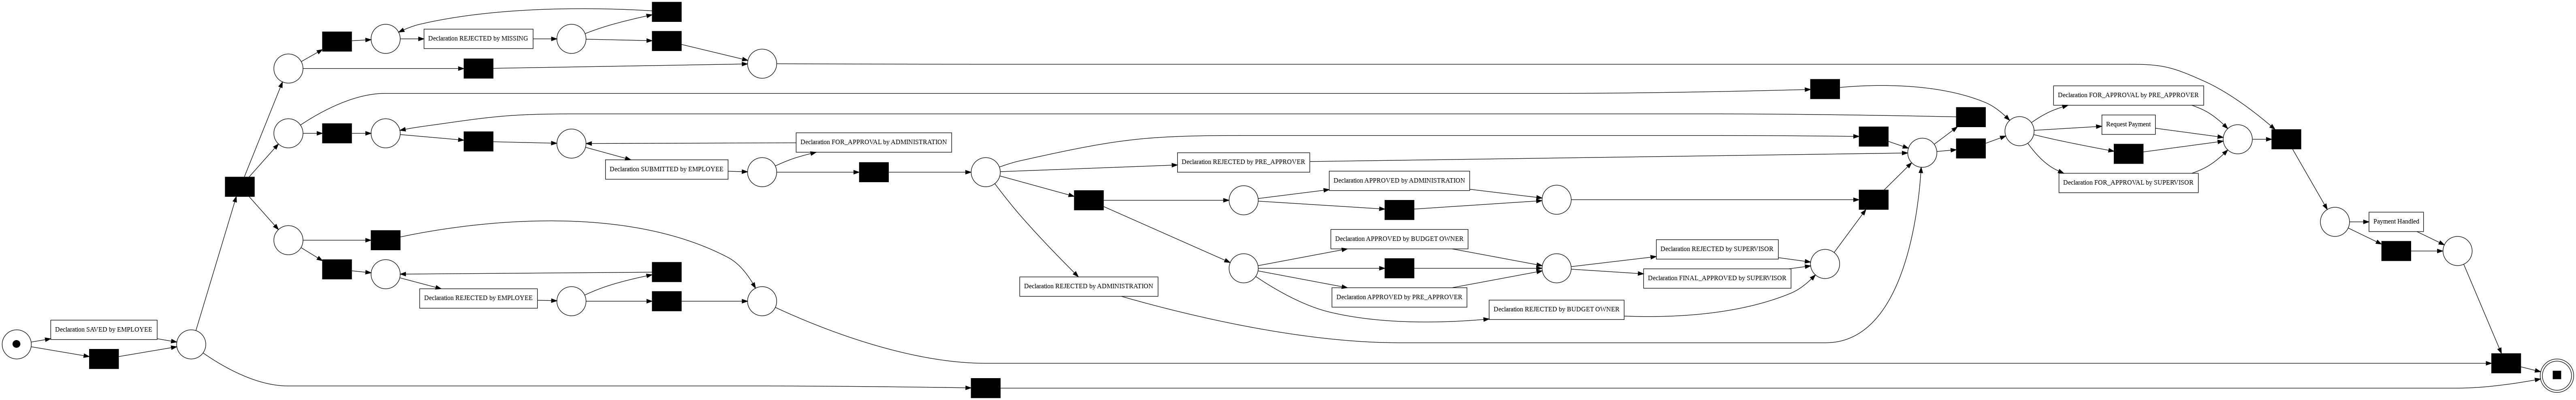

In [10]:
print("Best algorithm and parameters:")
print(study.best_params)

# Apply the best model to get the final process model
best_algorithm = study.best_params["algorithm"]
if best_algorithm == "alpha":
    final_net, final_initial_marking, final_final_marking = apply_alpha(log)
elif best_algorithm == "heuristic":
    best_dependency_thresh = study.best_params["dependency_thresh"]
    final_net, final_initial_marking, final_final_marking = apply_heuristic(log, dependency_thresh=best_dependency_thresh)
elif best_algorithm == "inductive":
    best_noise_threshold = study.best_params["noise_threshold"]
    final_net, final_initial_marking, final_final_marking = apply_inductive(log, noise_threshold=best_noise_threshold)

# Visualize the best model
gviz = pn_visualizer.apply(final_net, final_initial_marking, final_final_marking)
pn_visualizer.view(gviz)